In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import *
import matplotlib.pyplot as plt

First, read in problem parameters. These can come from any source, but they should be reshaped into a `pandas.DataFrame` object with the format shown here

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Key/value pairs are the names and contents of the sheets in the excel model data
model_dict = pd.read_excel('Example11_9_Network_Model_Aug2021.xlsx', sheet_name=None)

# Installed generation capacities
installed = np.array(model_dict['Gen']['Installed MW'])

# The initial conditions of the demand curves
load = model_dict['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = load.loc[:,load.columns.str.contains('Load')]/base
demand.columns = demand.columns.str.replace('Load','').astype(int)
price = load.loc[:,load.columns.str.contains('Price')]
price.columns = price.columns.str.replace('Price','').astype(int)

# Generation profiles for intermittant sources
int_gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
int_gen.index+=pd.TimedeltaIndex(int_gen.HE-1, unit='h')
int_gen = int_gen.drop(columns='HE')
int_gen = int_gen.loc[load.index, model_dict['Gen']['Type']]
int_gen = int_gen*installed/base
int_gen.columns = np.array(model_dict['Gen']['Number of Bus'])

# Set elasticity constant, for now
epsilon = demand.copy()
epsilon[:] = -.7

voll = price.copy()
voll[:] = 1000

profile = pd.concat(
    {
        'nom_load': demand,
        'nom_price': price,
        'elasticity': epsilon,
        'voll': voll,
        'int_gen': int_gen
    },
    axis='columns'
)
transition = 0.5
profile.int_gen = transition*profile.int_gen

To create the network mode, we also need the admittance matrix, line flow limits, storage duration, and generator limits/cost coefficients, as defined below.

In [3]:
# Process Ybus matrix
Y = model_dict['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model_dict['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Dispatchable generator costs, in the form [linear; quadratic]
cost_coeffs = np.array(
    [
        [10,8,12],
        [.016,0.18,0.18]
    ]
)

# Generator limits
dis_max = (1-transition)*installed/base

# Total storage capacity
total_storage = transition*installed.sum()/base

# Single-day run
profile = profile.loc[profile.index.day == profile.index.day[0]]

Instantiate model

In [4]:
model = Network(
    B=B,
    line_lims=P_line,
    profile=profile,
    dis_max=dis_max,
    total_storage=total_storage,
    storage_cycle_timesteps=b_duration,
    cost_coeffs=cost_coeffs,
    cycle_storage=True
)

def reset_to_nominal():
    '''resets the model to have nominal values - make sure anything being varied has its nominal value specified here.'''
    model.profile.elasticity = -0.7
    model.line_lims = P_line
    model.total_storage = total_storage
    model.cost_coeffs = cost_coeffs

Solve model. This will add output data to the `model.profile` dataframe as well as the following model attributes:
- `model.storage_capacity`: the storage capacity allocated to each bus
- `model.initial_charge`: the initial state-of-charge of each storage unit

In [5]:
model.solve()

Plot all the prices and their nominal values (dotted). Bus 1 has no nominal price because it does not have a load.

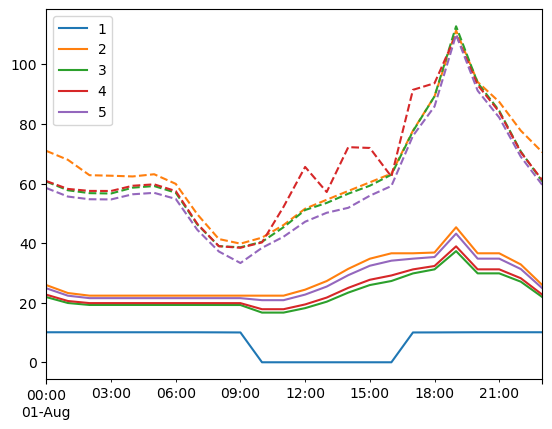

In [6]:
fig, ax = plt.subplots()
model.profile.price.plot(ax=ax)
# Save colors for consistency
colors = np.array([line.get_color() for line in ax.lines])
ax.set_prop_cycle(None)
model.profile.nom_price.plot(ax=ax,style='--',color=colors[model.profile.nom_price.columns-1],legend=False)
fig.show()

Similar idea with the loads - nominal dotted, actual solid

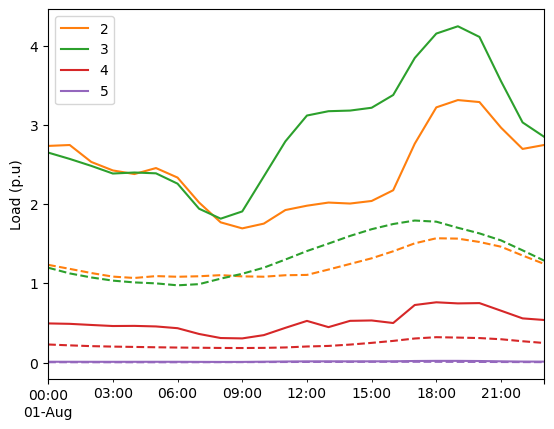

In [7]:
fig, ax = plt.subplots()
model.profile.load.plot(ax=ax,color=colors[model.profile.load.columns-1])
model.profile.nom_load.plot(ax=ax,style='--',color=colors[model.profile.load.columns-1],legend=False)
ax.set_ylabel('Load (p.u)')
fig.show()

Compute the dispatchable and intermittent (dotted) generation

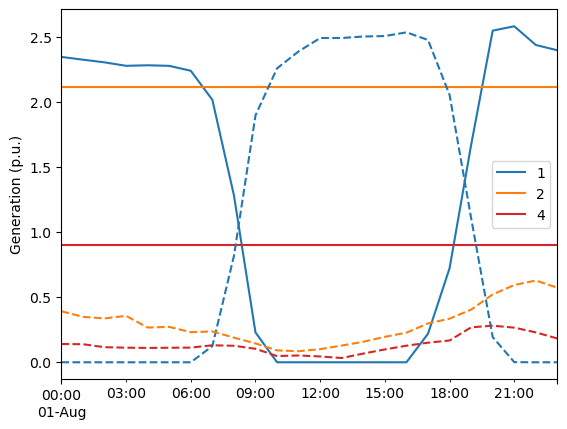

In [8]:
dispatchable = model.profile.generation - model.profile.int_gen
dispatchable[dispatchable < 0] = 0
intermittent = model.profile.generation - dispatchable

fig, ax = plt.subplots()
dispatchable.plot(ax=ax,color=colors[dispatchable.columns-1])
intermittent.plot(ax=ax,style='--',color=colors[intermittent.columns-1],legend=False)
ax.set_ylabel('Generation (p.u.)')
fig.show()

Compute producer (solid) and consumer (dashed) surplus according to:
- Consumer surplus = revenue - cost
- Producer surplus = utility - expenses

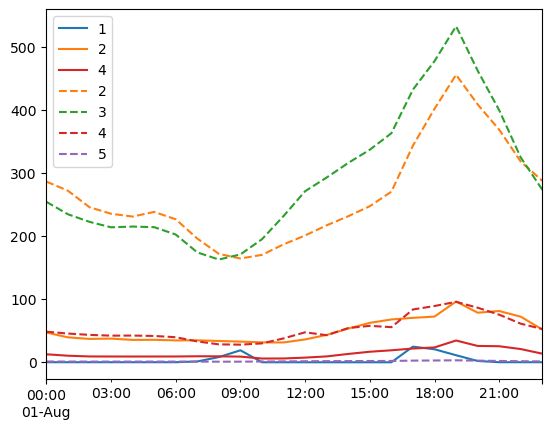

In [9]:
producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]

fig, ax = plt.subplots()
producer_surplus.plot(ax=ax,color=colors[producer_surplus.columns-1])
consumer_surplus.plot(ax=ax,style='--',color=colors[consumer_surplus.columns-1])
fig.show()

Compute line loading, as a percentage. A negative value indicates power is flowing in the reverse direction with respect to the legend.

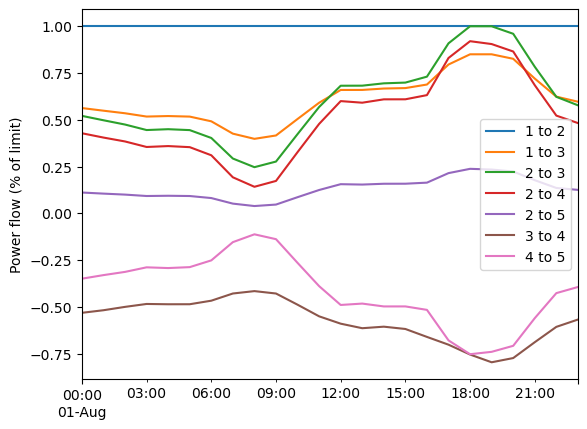

In [10]:
origin, destination = np.triu_indices(model.B.shape[0],1)
line_flows = model.profile.angle.apply(
    lambda row: pd.Series((model.B*outer_difference(row.to_numpy()))[(origin,destination)]),
    axis='columns'
)
line_flows.columns = [f'{origin[k]+1} to {destination[k]+1}' for k in range(len(line_flows.columns))]
lims = model.line_lims[(origin,destination)]
edge_idx = np.nonzero(lims)[0]
line_flows = line_flows.iloc[:,edge_idx]/lims[edge_idx]

fig, ax = plt.subplots()
line_flows.plot(ax=ax)
ax.set_ylabel('Power flow (% of limit)')
fig.show()

State-of-charge computation

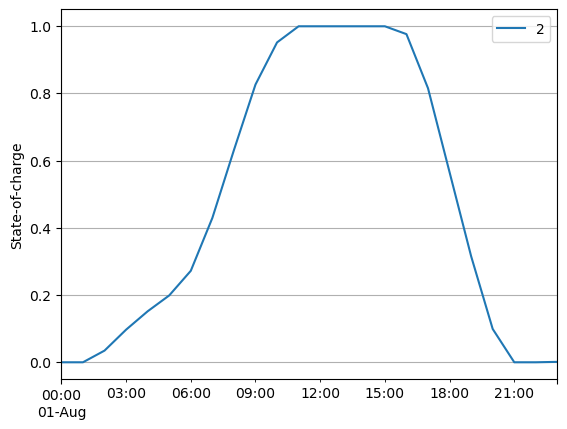

In [11]:
storage_mask = model.storage_capacity >= 1e-3
soc = model.initial_charge + model.profile.storage_load.cumsum()
soc = soc.loc[:,storage_mask]/model.storage_capacity[storage_mask]

fig, ax = plt.subplots()
soc.plot(ax=ax)
ax.set_ylabel('State-of-charge')
ax.grid()
fig.show()

Produce transition plots for nominal parameter values.

In [12]:
reset_to_nominal()
nom_results = {}
for t in np.linspace(0.1, 0.9, 9):
# for t in [0.1]:
    print('Computing for transition = '+str(t)+'...')
    model.profile.int_gen = t*int_gen
    model.dis_max = (1-t)*installed/base
    model.total_storage = t*installed.sum()/base
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]
    dispatchable = model.profile.generation - model.profile.int_gen
    dispatchable[dispatchable < 0] = 0
    intermittent = model.profile.generation - dispatchable
    dispatchable_surplus = dispatchable*model.profile.price[dispatchable.columns]-model.profile.cost
    intermittent_surplus = intermittent*model.profile.price[intermittent.columns]
    nom_results[t] = pd.Series(
        {
            'load': model.profile.load.sum().sum(),
            'load_minus_nom': (model.profile.load - model.profile.nom_load).sum().sum(),
            'dispatchable': dispatchable.sum().sum(),
            'intermittent': intermittent.sum().sum(),
            'dispatchable_surplus': dispatchable_surplus.sum().sum()/(1-t)/installed.sum(),
            'intermittent_surplus': intermittent_surplus.sum().sum()/t/installed.sum(),
            'producer_surplus': producer_surplus.sum().sum()/installed.sum(),
            'average_price': model.profile.price.mean(axis=None),
            'max_price': model.profile.price.max(axis=None),
            'min_price': model.profile.price.min(axis=None),
            'std_price': np.std(model.profile.price.to_numpy().flatten())
        }
    )
nom_results = pd.DataFrame(nom_results).T
nom_results.index.name = 'transition'
nom_results

Computing for transition = 0.1...
Computing for transition = 0.2...
Computing for transition = 0.30000000000000004...
Computing for transition = 0.4...
Computing for transition = 0.5...
Computing for transition = 0.6...
Computing for transition = 0.7000000000000001...
Computing for transition = 0.8...
Computing for transition = 0.9...


,load,load_minus_nom,dispatchable,intermittent,dispatchable_surplus,intermittent_surplus,producer_surplus,average_price,max_price,min_price,std_price
transition,,,,,,,,,,,
0.1,185.392551,117.535872,177.528202,7.864349,0.853339,0.679605,0.835965,16.356961,43.727438,1.006517e+01,7.569737
0.2,177.520042,109.663363,161.791343,15.728699,0.962239,0.694213,0.908634,17.165976,44.263912,1.004347e+01,7.796501
0.3,167.004000,99.147321,143.410952,23.593048,1.121449,0.714254,0.999290,18.341874,44.811046,1.002132e+01,7.984843
0.4,153.681259,85.824580,122.223861,31.457398,1.362086,0.710523,1.101461,20.059884,45.369558,3.123088e+00,8.200981
0.5,140.487520,72.630841,104.340453,36.147067,1.685186,0.510259,1.097723,21.832609,45.314683,5.106485e-07,9.560385
0.6,127.064638,59.207959,87.933007,39.131631,2.084602,0.501713,1.134869,24.636441,45.151518,1.212521e-07,10.633684
0.7,113.593036,45.736357,71.074716,42.518320,2.603289,0.542807,1.160952,28.442171,49.554550,1.564539e-07,12.370638
0.8,99.930490,32.073811,51.977077,47.953413,3.526398,0.633349,1.211959,33.663434,60.380863,3.132114e-08,14.415759
0.9,82.838263,14.981584,26.164600,56.673663,6.575717,0.800180,1.377734,44.875815,97.607075,4.550137e-07,19.307846


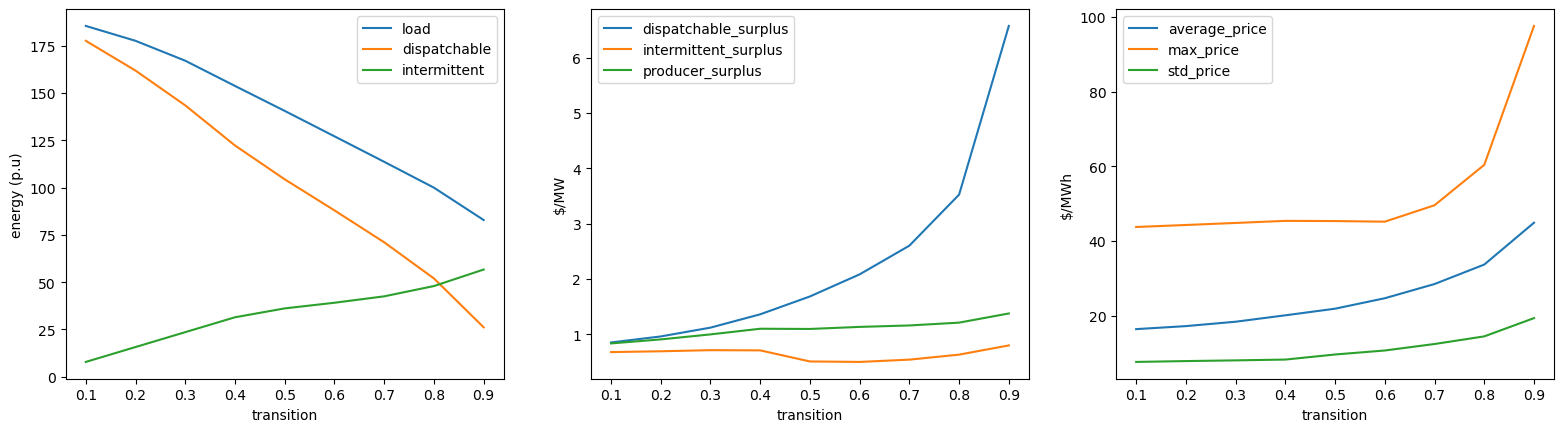

In [13]:
fig, ax = plt.subplots(1,3)
nom_results[['load','dispatchable','intermittent']].plot(ax=ax[0])
nom_results[['dispatchable_surplus','intermittent_surplus','producer_surplus']].plot(ax=ax[1])
nom_results[['average_price','max_price','std_price']].plot(ax=ax[2])
[a.set_xlabel('transition') for a in ax]
ax[0].set_ylabel('energy (p.u)')
ax[1].set_ylabel('$/MW')
ax[2].set_ylabel('$/MWh')
fig.set_size_inches(fig.get_size_inches()*[3,1])

Produce sensitivity plots showing sensitivity of producer surplus, consumer surplus, and average price to parameter values.

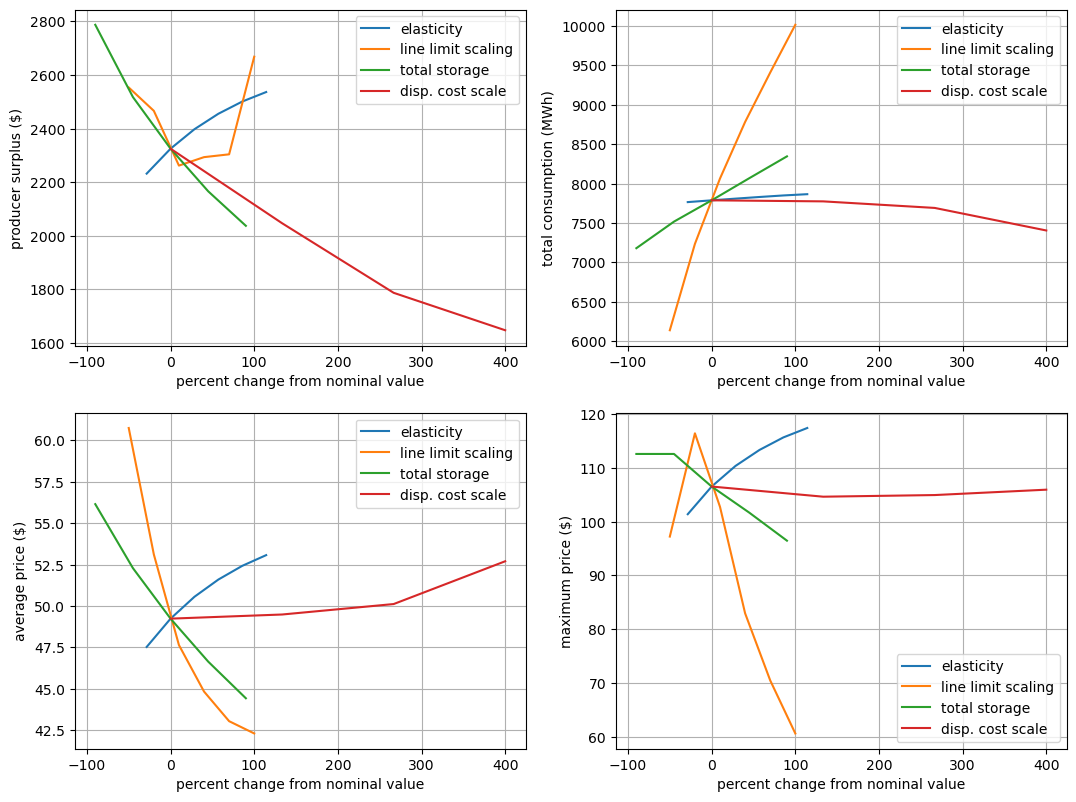

In [14]:
# Produce spiky plot - x axis is % change in input from its reference, y is measure of variable of interest.
    
def run_analysis(model, current_val, nominal_val):
    model.solve()
    producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
    output = pd.Series(
        {
            'producer_surplus': producer_surplus.sum().sum(),
            'total_consumption': base*model.profile.load.sum().sum(),
            'average_price': model.profile.price.mean(axis=None),
            'max_price': model.profile.price.max(axis=None),
            'total_surplus': producer_surplus.sum().sum() + consumer_surplus.sum().sum(),
            'xlabl': 100*(current_val/nominal_val - 1)
        }
    )
    return output

def sensitivity_plot(results):
    results = pd.DataFrame(results).T
    results.plot(y='producer_surplus', x='xlabl', ax=ax[0,0])
    results.plot(y="total_consumption", x="xlabl", ax=ax[0,1])
    results.plot(y="average_price", x="xlabl", ax=ax[1,0])
    results.plot(y="max_price", x="xlabl", ax=ax[1,1])
    
fig, ax = plt.subplots(2,2)

# Vary elasticity 
results = {}
reset_to_nominal()
for i in np.linspace(-1.5, -.5, 6):
    model.profile.elasticity = i
    results[i] = run_analysis(model, i, -0.7)
sensitivity_plot(results)

# Line limit scaling 
results = {}
reset_to_nominal()
for i in np.linspace(0.5, 2.0, 6):
     model.line_lims = P_line*i
     results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

# Storage scaling
results = {}
reset_to_nominal()
for i in np.linspace(.1*total_storage, 1.9*total_storage, 5):
    model.total_storage = i
    results[i] = run_analysis(model, i, total_storage)
sensitivity_plot(results)

# generator costs  
results = {}
reset_to_nominal()
for i in np.linspace(1, 5, 4):
    model.cost_coeffs = cost_coeffs*i
    results[i] = run_analysis(model, i, 1.0)
sensitivity_plot(results)

[a.set_xlabel('percent change from nominal value') for row in ax for a in row]
ax[0,0].set_ylabel('producer surplus ($)')
ax[0,1].set_ylabel('total consumption (MWh)')
ax[1,0].set_ylabel('average price ($)')
ax[1,1].set_ylabel('maximum price ($)')
[a.grid() for row in ax for a in row]
fig.set_size_inches(fig.get_size_inches()*[2,2])
[a.legend(['elasticity', 'line limit scaling', 'total storage', 'disp. cost scale']) for row in ax for a in row]

fig.show()